<!-- Centered layout with a university logo -->
<div align="center">

  <!-- University Logo -->
  <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width="180" height="180" style="margin-bottom: 10px;">
  
  <!-- Assignment Title -->
  <h1></h1>
  <h1 style="color:#0F5298; font-size: 40px; font-weight: bold; margin-bottom: 5px;">Deep Reinforcement Learning</h1>
  <h2 style="color:#0F5298; font-size: 32px; font-weight: normal; margin-top: 0px;">Assignment 06 - Multi-Armed and Contextual Bandits</h2>

  <!-- Department and University -->
  <h3 style="color:#696880; font-size: 24px; margin-top: 20px;">Computer Engineering Department</h3>
  <h3 style="color:#696880; font-size: 22px; margin-top: -5px;">Sharif University of Technology</h3>

  <!-- Semester -->
  <h3 style="color:#696880; font-size: 22px; margin-top: 20px;">Spring 2025</h3>

  <!-- Authors -->
  <h3 style="color:green; font-size: 22px; margin-top: 20px;">Full name: [FULL_NAME]</h3>
  <h3 style="color:green; font-size: 22px; margin-top: 20px;">Student ID: [STUDENT_ID]</h3>

  <!-- Horizontal Line for Separation -->
  <hr style="border: 1px solid #0F5298; width: 80%; margin-top: 30px;">

</div>


## Setup & Overview  
In this notebook, we simulate bandit problems using *MAB* (Multi-Armed Bandit) and *CtxBnd* (Contextual Bandit) frameworks.  
We compare several agents:
- **Oracle** (with privileged info)
- **RndAg** (Random Agent)
- **ExpFstAg** (Explore-First Agent)
- **UCB_Ag** (UCB Agent)
- **EpsGdAg** (Epsilon-Greedy Agent)
- **LinUCB_Ag** (LinUCB for contextual bandits)


Follow the instructions carefully and complete the sections marked with **TODO**.

## Setup and Environment

In the upcoming cells, we import necessary libraries, set up utility functions for reproducibility and plotting, and define the basic components of our bandit experiments.


In [70]:
# %% [code]
import numpy as np
import random
import time
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from dataclasses import dataclass
from copy import deepcopy
from tqdm.notebook import tqdm

plt.rcParams['figure.dpi'] = 100

In [71]:
# %% [code]
def plot_logs(df, x_key, y_key, legend_key, **kwargs):
    num = len(df[legend_key].unique())
    pal = sns.color_palette("hls", num)
    if 'palette' not in kwargs:
        kwargs['palette'] = pal
    ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)
    return ax

def set_seed(s):
    np.random.seed(s)
    random.seed(s)

set_seed(0)

## MAB Overview  
We consider a bandit with 10 arms. Two formulations:  
- **Stochastic:** Each arm gives a reward of 1 with probability *p*.  
- **Deterministic:** Each arm always returns a fixed reward.  
  
We'll work with the stochastic case. The reward probabilities will be set randomly.

In [72]:
# %% [code]
nArms = 10
p_arr = [np.random.random() for _ in range(nArms)]
print("Probabilities:", p_arr)

Probabilities: [0.5488135039273248, 0.7151893663724195, 0.6027633760716439, 0.5448831829968969, 0.4236547993389047, 0.6458941130666561, 0.4375872112626925, 0.8917730007820798, 0.9636627605010293, 0.3834415188257777]


**Q:** How might the performance of different agents change if the distribution of probabilities were not uniform?  

**A:** PUT YOUR ANSWER HERE :)

If the distribution is not uniform, agents behave differently:

Random Agent performs poorly, stuck near the average of all arm rewards.

Explore-Then-Exploit can perform well if max_ex is tuned properly.

With too little exploration, it may miss the best arm entirely.

With too much, it wastes time on bad arms.

In skewed settings, performance gaps between agents become more obvious.

Smarter agents (like epsilon-greedy or UCB) outperform others by adapting.

Overall, skewed distributions reward agents that learn and exploit effectively.


In [73]:
# %% [code]
@dataclass
class MAB_Env:
    p_arr: np.ndarray

    def step(self, act):
        return 1 if np.random.random() < self.p_arr[act] else 0

**Q:** Why does the MAB environment use a simple binary reward mechanism (1 or 0)?

**A:** PUT YOUR ANSWER HERE :)

The Multi-Armed Bandit (MAB) environment typically uses a binary reward mechanism (1 for success, 0 for failure) because it models the simplest and most fundamental form of stochastic decision-making — similar to flipping biased coins. This setup captures the core exploration-exploitation dilemma while keeping the environment easy to simulate and analyze. Binary rewards are also common in real-world scenarios like ad clicks, medical trials, or A/B testing, where outcomes are often success/failure. By simplifying the reward structure, researchers can focus on comparing algorithms' learning efficiency and decision-making strategies without the added complexity of continuous or structured rewards.

In [74]:
# %% [code]
@dataclass
class MAB_Eng:
    p_arr: np.ndarray
    max_steps: int
    agent: any

    def __post_init__(self):
        self.env = MAB_Env(p_arr=self.p_arr)

    def run(self, n_runs=1):
        logs = []
        for _ in tqdm(range(n_runs), desc='Runs'):
            run_rewards = []
            run_acts = []
            self.agent.reset()
            for t in range(self.max_steps):
                act = self.agent.get_action()
                rew = self.env.step(act)
                self.agent.update_Q(act, rew)
                run_acts.append(act)
                run_rewards.append(rew)
            logs.append(pd.DataFrame({
                'reward': run_rewards,
                'action': run_acts,
                'step': np.arange(len(run_rewards))
            }))
        return pd.concat(logs, ignore_index=True)

In [75]:
# %% [code]
def mab_swp(agents, p_arr, labels, n_runs=2000, max_steps=500):
    all_logs = []
    for idx, agent in enumerate(tqdm(agents, desc="Alg Sweeps")):
        engine = MAB_Eng(p_arr=p_arr, max_steps=max_steps, agent=agent)
        log_df = engine.run(n_runs)
        log_df['Alg'] = labels[idx]
        all_logs.append(log_df)
    return pd.concat(all_logs, ignore_index=True)

## Oracle Agent  
The **Oracle** has full knowledge of *p_arr*.  
**Question:** What is the maximum expected per-step reward?

In [76]:
# TODO: Compute oracleReward using privileged info (simple placeholder)
oracleReward = np.max(p_arr)  # Placeholder
print(f'Max possible reward (Simple): {oracleReward}')

Max possible reward (Simple): 0.9636627605010293


**Q:** What insight does the oracle reward give us about the best possible performance?

**A:** PUT YOUR ANSWER HERE :)


The oracle reward represents the highest expected reward achievable by always selecting the optimal arm — the one with the highest probability of success. It serves as a theoretical upper bound or gold standard for performance in the Multi-Armed Bandit problem. By comparing an agent's reward curve to the oracle reward, we can gauge how close the agent is to optimal behavior and how much room there is for improvement. This insight helps in evaluating the effectiveness of learning strategies, highlighting whether an agent is efficiently identifying and exploiting the best action over time.

-------------------

**Q:** Why is the oracle considered “cheating” in a practical sense?  

**A:** PUT YOUR ANSWER HERE :)

The oracle is considered "cheating" in a practical sense because it has perfect knowledge of the underlying probabilities of each arm, which is not available to real-world agents. In reality, agents must explore and learn from trial and error without prior knowledge of the environment. The oracle's ability to always choose the best action eliminates the need for learning or adaptation, making it an unrealistic benchmark. This makes it a useful theoretical tool but not a practical solution for real-world decision-making problems where agents must rely on incomplete or uncertain information.

## RndAg (Random Agent)  
This agent selects an action at random at every timestep. It does no learning.


In [77]:
@dataclass
class RndAg:
    n_act: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        pass  # No learning

    def get_action(self):
        self.t += 1
        # TODO: get a random action index [Simple]
        sel_act = np.random.randint(self.n_act)
        return sel_act


In [78]:
# %% [code]
rnd_agent = RndAg(n_act=len(p_arr))
n_runs = 1000
rnd_log = mab_swp([rnd_agent], p_arr, ['Rnd'], n_runs=n_runs)

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-71-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


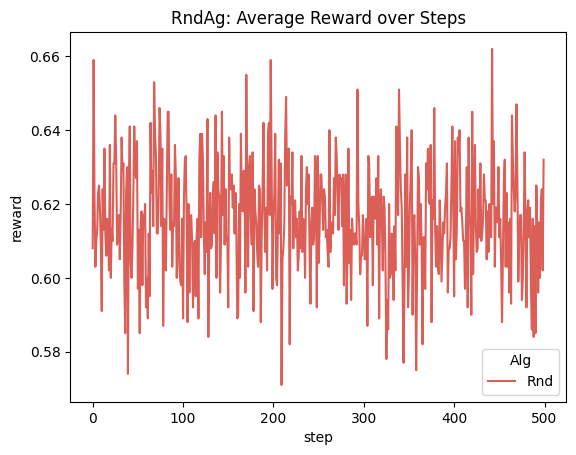

In [79]:
# %% [code]
plot_logs(rnd_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("RndAg: Average Reward over Steps")
plt.show()

**Q:** Why is the reward of the random agent generally lower and highly variable?

**A:** PUT YOUR ANSWER HERE :)

The reward of the random agent is generally lower and highly variable because it selects actions without any regard for the quality of the arms. Since it chooses arms uniformly at random, it may frequently choose suboptimal arms that yield lower rewards. This randomness leads to high variability in the reward, as the agent has no mechanism for exploiting better arms or learning from past actions. Over time, it’s unlikely to consistently pick high-reward arms, resulting in lower average rewards and high fluctuation, especially when compared to more intelligent agents that adapt based on experience.

------------

**Q:** How might you improve a random agent without using any learning mechanism?

**A:** PUT YOUR ANSWER HERE :)

To improve a random agent without using any learning mechanism, you could implement an exploration strategy that biases the action selection towards better-performing arms over time. One simple way is to use non-uniform random sampling based on a fixed exploration budget. For example:

Epsilon-Greedy without learning: Let the agent explore randomly with a certain probability (epsilon), and exploit the best arm with the remaining probability. This gives the agent a chance to discover better arms while occasionally exploiting its best-known arm.

Thompson Sampling (non-learning version): You could simulate a more sophisticated random approach like Thompson Sampling, where each arm’s probability of being chosen is based on how successful it has been so far (using a pre-set heuristic or counter instead of learning).

These strategies still rely on randomization but improve performance by guiding the agent towards better arms in a controlled, non-learning way.

<ipython-input-71-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


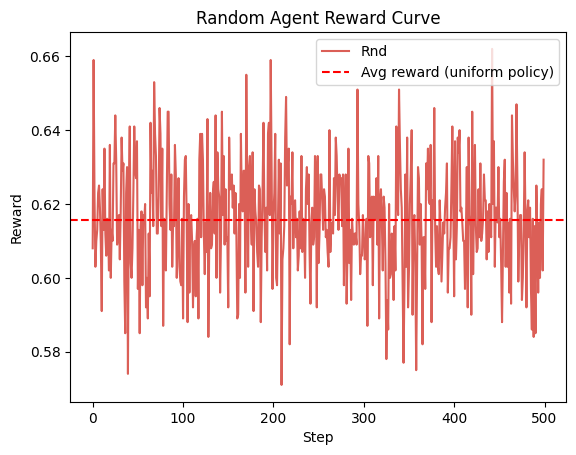

In [80]:
plot_logs(rnd_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)

# Add average reward line (mean of p_arr)
avg_reward = np.mean(p_arr)
plt.axhline(avg_reward, color='red', linestyle='--', label='Avg reward (uniform policy)')

plt.legend()
plt.title("Random Agent Reward Curve")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.show()

**Analysis:**  
- The x-axis shows the number of steps; y-axis shows average reward.  
- Regret is the gap between Oracle and agent performance.

## ExpFstAg (Explore-First Agent)  
This agent explores randomly for the first *max_ex* steps, then exploits the best arm thereafter.

In [81]:
from dataclasses import dataclass
import numpy as np

@dataclass
class ExpFstAg:
    n_act: int
    max_ex: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        # TODO: update Q value (Simple placeholder)
        self.act_counts[act] += 1
        alpha = 1 / self.act_counts[act]  # learning rate = 1/N
        self.Q[act] += alpha * (rew - self.Q[act])

    def get_action(self):
        self.t += 1
        # TODO: Choose random action for t <= max_ex, else best arm [Simple]
        if self.t <= self.max_ex:
            sel_act = np.random.randint(self.n_act)
        else:
            sel_act = np.argmax(self.Q)
        return sel_act


### Run ExpFstAg with max_ex = 5  
We will test ExpFstAg (with 5 exploration steps) over 1000 runs and 500 steps.

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-71-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


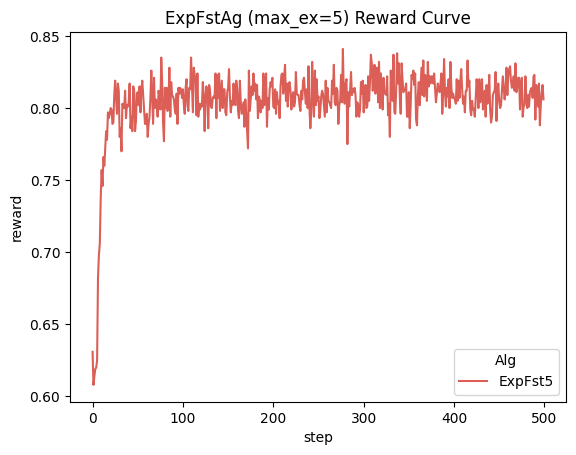

In [82]:
# %% [code]
max_ex = 5
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=max_ex)
expfst_log = mab_swp([expfst_agent], p_arr, [f'ExpFst{max_ex}'], n_runs=1000, max_steps=500)
plot_logs(expfst_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title(f"ExpFstAg (max_ex={max_ex}) Reward Curve")
plt.show()

**Analysis:**  
- The ExpFstAg should outperform RndAg by identifying the best arm during exploration.  
- However, with too short exploration, it may miss the best arm.

----------

**Q:** Why might the early exploration phase (e.g., 5 steps) lead to high fluctuations in the reward curve?  


**A:** PUT YOUR ANSWER HERE :)

The early exploration phase (e.g., 5 steps) might lead to high fluctuations in the reward curve because the agent is randomly selecting arms, without any knowledge of which arm is better. This randomness means the agent may often choose suboptimal arms, leading to unpredictable rewards. Since the agent hasn't yet identified the best arm and is still exploring, the reward curve can be highly variable during this phase. Additionally, if the exploration phase is too short, the agent might not gather enough information to make an informed decision, causing early rewards to be inconsistent and fluctuating.

------------
**Q:** What are the trade-offs of using a fixed exploration phase?


**A:** PUT YOUR ANSWER HERE :)

Using a fixed exploration phase introduces several trade-offs:

Pros:

Simplicity: A fixed exploration phase is easy to implement and understand.

Reduced Complexity: It avoids the need for adaptive exploration strategies, such as those based on rewards or dynamic factors.

Initial Exploration: Ensures that the agent explores different arms before exploiting the best one, reducing the risk of immediately converging to a suboptimal choice.

Cons:

Inefficiency: If the fixed exploration phase is too short, the agent may not explore enough to identify the best arm, leading to poor performance. If it's too long, the agent may waste time exploring suboptimal arms, delaying exploitation.

Lack of Adaptability: A fixed exploration phase doesn't adjust based on the environment or performance, so it may not suit situations where exploration is required for longer or shorter periods based on variability in arm rewards.

No Learning Feedback: The agent may miss the opportunity to adaptively adjust its exploration-exploitation balance as it learns about the arms.

Running ExpFstAg with max_ex=5...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running ExpFstAg with max_ex=10...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running ExpFstAg with max_ex=50...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running ExpFstAg with max_ex=100...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running ExpFstAg with max_ex=200...


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-71-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


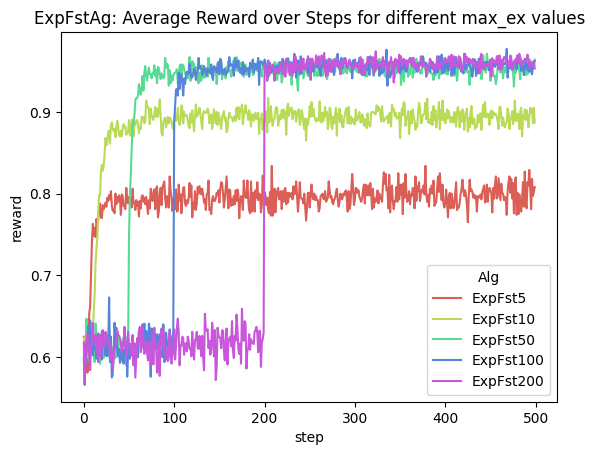

In [83]:
# Run ExpFstAg for various max_ex values: [5, 10, 50, 100, 200] and plot their reward curves
expfst_logs = []

for ex in [5, 10, 50, 100, 200]:
    print(f"Running ExpFstAg with max_ex={ex}...")
    agent = ExpFstAg(n_act=len(p_arr), max_ex=ex)
    log_df = mab_swp([agent], p_arr, [f'ExpFst{ex}'], n_runs=1000, max_steps=500)
    expfst_logs.append(log_df)

combined_logs = pd.concat(expfst_logs, ignore_index=True)

ax = plot_logs(combined_logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("ExpFstAg: Average Reward over Steps for different max_ex values")
plt.show()


**Observations:**  
- Short exploration (e.g., 5 or 10 steps) may not reliably find the best arm.  
- Longer exploration (e.g., 50 or 100 steps) improves performance but may delay exploitation.

**Q:** How does increasing `max_ex` affect the convergence of the agent’s performance?


**A:** PUT YOUR ANSWER HERE :)

Increasing max_ex allows the agent more time to explore different arms, which improves the likelihood of discovering the best arm, leading to better long-term performance. With longer exploration, the agent is less likely to prematurely exploit suboptimal arms, which reduces the risk of early suboptimal convergence. However, while longer exploration can improve the accuracy of the agent's decision-making, it delays the exploitation phase, which might slow down convergence to the optimal arm. Essentially, there is a trade-off: more exploration leads to better identification of the best arm but at the cost of a slower start to exploiting that knowledge.

------------------------------

**Q:** In real-world scenarios, what challenges might arise in selecting the optimal exploration duration?

**A:** PUT YOUR ANSWER HERE :)

In real-world scenarios, selecting the optimal exploration duration can be challenging because the environment is often dynamic, with changing probabilities, noisy data, and uncertain outcomes. Fixed exploration durations may not be ideal if the environment's conditions evolve over time, as the agent may need longer or shorter exploration phases depending on the variability in rewards. Additionally, real-world constraints such as limited time, computational resources, or the need for quick decision-making might force a balance between exploration and exploitation that isn't easily predictable. Furthermore, the agent might not always have access to the kind of feedback or data needed to adjust exploration durations effectively, leading to either premature exploitation or excessive exploration that wastes valuable resources.


## UCB_Ag (UCB Agent)  
UCB dynamically balances exploration and exploitation by adding an exploration bonus to Q-values.

In [84]:
@dataclass
class UCB_Ag:
    n_act: int

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.t = 0
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        # TODO: Update Q value (Simple placeholder)
        self.act_counts[act] += 1
        self.Q[act] += (rew - self.Q[act]) / self.act_counts[act]

    def get_action(self):
        self.t += 1
        delta = 1e-5  # to avoid division by zero
        # TODO: Compute exploration bonus (Simple placeholder)
        bonus = np.sqrt((2 * np.log(self.t + delta)) / (self.act_counts + delta))
        Q_explore = self.Q + bonus
        sel_act = np.random.choice(np.flatnonzero(Q_explore == Q_explore.max()))
        return sel_act

Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-71-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


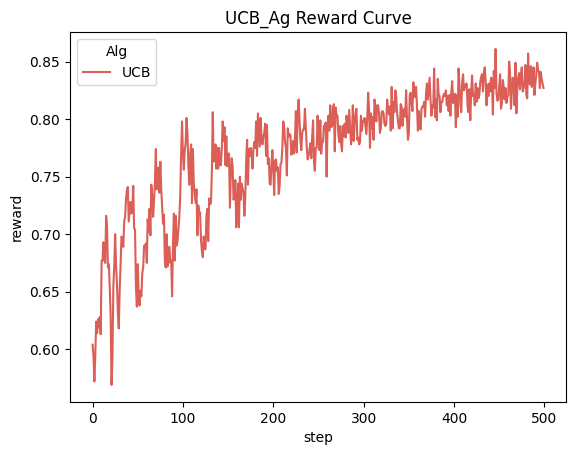

In [85]:
# %% [code]
ucb_agent = UCB_Ag(n_act=len(p_arr))
ucb_log = mab_swp([ucb_agent], p_arr, ['UCB'], n_runs=1000, max_steps=500)
plot_logs(ucb_log, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("UCB_Ag Reward Curve")
plt.show()

**Q:** Under what conditions might an explore-first strategy outperform UCB, despite UCB’s theoretical optimality?

**A:** PUT YOUR ANSWER HERE :)

An explore-first strategy might outperform UCB in environments with very low noise and clearly distinguishable arm probabilities, where a short, focused exploration phase is enough to accurately identify the best arm. In such cases, switching quickly to exploitation allows the agent to maximize rewards without the overhead of continuous exploration. Additionally, in short-horizon scenarios, where decisions must be made quickly and there's limited time for learning, the explore-first approach can yield better cumulative rewards because UCB may spend too much time cautiously exploring. Finally, if the UCB parameters are not well-tuned for the specific environment or if computational simplicity is critical, the deterministic nature of explore-first may make it more practical and effective in certain real-world settings.

-----------------
**Q:** How do the design choices of each algorithm affect their performance in short-term versus long-term scenarios?

**A:** PUT YOUR ANSWER HERE :)

The design choices of each algorithm significantly influence their performance in short-term versus long-term scenarios. Random agents, with no learning or strategy, tend to perform poorly in both cases. Explore-first agents are simple and can do well in short-term settings if the exploration phase is just right—too little leads to poor choices, while too much wastes valuable time. In contrast, UCB agents are designed for long-term optimality, as they continually balance exploration and exploitation based on statistical confidence; this helps them converge to the best arm over time, but can lead to slower performance early on due to ongoing exploration. Thus, while explore-first might achieve better short-term rewards under certain conditions, algorithms like UCB generally outperform in the long run by adapting more robustly to uncertainty and accumulating better overall reward.

## UCB vs. ExpFstAg  
Now we compare UCB_Ag and ExpFstAg (with max_ex = 5) side by side.


**Question:**  
Why does UCB learn slowly (even after 500 steps, not reaching maximum reward)?  
*Hint:* Consider the conservative nature of the exploration bonus.


Running comparison (Simple)...


Alg Sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-71-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


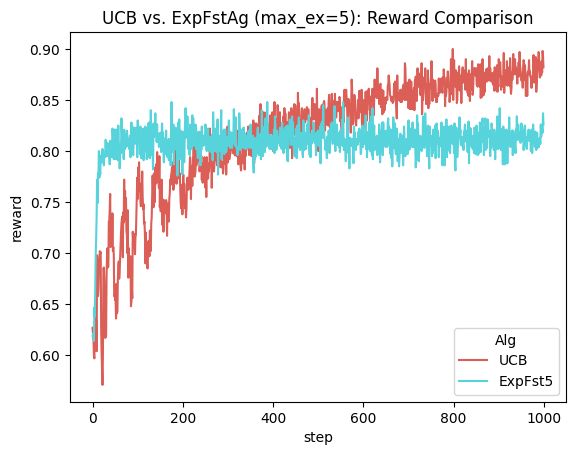

In [86]:
# Assuming required components like MAB_Env, run_bandit, and plot_logs are already defined

print("Running comparison (Simple)...")

ucb_agent = UCB_Ag(n_act=len(p_arr))
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=5)

# Run the experiments for both agents
logs = mab_swp(
    agents=[ucb_agent, expfst_agent],
    p_arr=p_arr,
    labels=['UCB', 'ExpFst5'],
    n_runs=1000,
    max_steps=1000
)

# Plot the comparison of average rewards over steps for both agents
ax = plot_logs(logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("UCB vs. ExpFstAg (max_ex=5): Reward Comparison")
plt.show()

**Q:** Under what conditions might an explore-first strategy outperform UCB, despite UCB’s theoretical optimality?

**A:** PUT YOUR ANSWER HERE :)

An explore-first strategy might outperform UCB in scenarios with a short time horizon, where quick decisions are needed and the cost of continued exploration outweighs potential long-term gains. In such cases, dedicating a small number of initial steps to exploration followed by pure exploitation can lead to higher cumulative rewards. This strategy also performs well in low-noise or deterministic environments, where a brief exploration is sufficient to identify the best arm reliably. Moreover, if computational simplicity or limited resources are a constraint, explore-first can be more practical than UCB, which requires ongoing computation of confidence bounds. Finally, if the differences between arm rewards are large, even minimal exploration might suffice, allowing explore-first to converge faster than UCB, which cautiously explores throughout.

---------------

**Q:** How do the design choices of each algorithm affect their performance in short-term versus long-term scenarios?

**A:** PUT YOUR ANSWER HERE :)

When comparing UCB and ExpFst (with max_ex=5), their design choices lead to distinct performance patterns in short-term versus long-term scenarios. ExpFst5 allocates only the first 5 steps for exploration, then commits to exploiting the best-found arm. This can result in good short-term performance if the initial exploration happens to sample the optimal or near-optimal arm, but it risks locking into suboptimal choices due to limited information. In contrast, UCB continuously balances exploration and exploitation by assigning confidence-based bonuses to less-sampled arms. While this cautious approach may cause slower initial performance, it typically leads to better long-term rewards as the agent refines its estimates and converges on the best arm over time. Thus, ExpFst5 is more suited to quick, one-shot scenarios, while UCB is better for sustained learning and optimality in longer runs.

**Question:**  
What happens if we let ExpFstAg explore for 20 steps? Compare its reward to UCB.

Running UCB vs. ExpFstAg (max_ex=20) comparison... (Simple)


Alg Sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-71-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


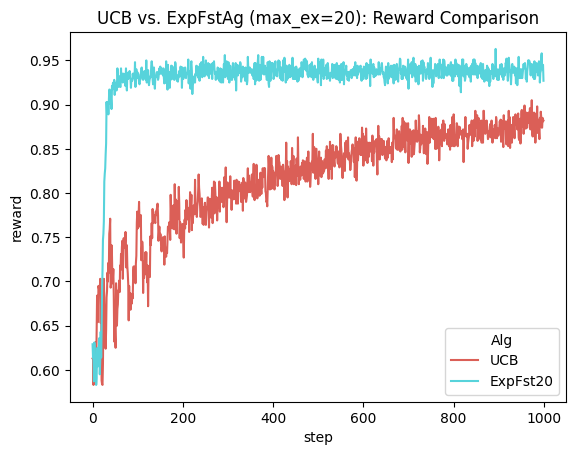

In [87]:
# Run comparison for ExpFstAg (max_ex=20) and UCB_Ag (Simple placeholder)
print("Running UCB vs. ExpFstAg (max_ex=20) comparison... (Simple)")

ucb_agent = UCB_Ag(n_act=len(p_arr))
expfst_agent = ExpFstAg(n_act=len(p_arr), max_ex=20)

logs = mab_swp(
    agents=[ucb_agent, expfst_agent],
    p_arr=p_arr,
    labels=['UCB', 'ExpFst20'],
    n_runs=1000,
    max_steps=1000
)

ax = plot_logs(logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("UCB vs. ExpFstAg (max_ex=20): Reward Comparison")
plt.show()


**Q:** What impact does increasing the exploration phase to 20 steps have compared to 5 steps?

**A:** PUT YOUR ANSWER HERE :)

Increasing the exploration phase from 5 to 20 steps allows the agent to gather more information about each arm, which improves its chances of correctly identifying the optimal one before committing to exploitation. This typically results in a slightly lower short-term reward due to the extended exploration period, but it often leads to better long-term performance compared to the 5-step version. With only 5 steps, the agent may prematurely exploit a suboptimal arm due to limited data, while 20 steps provide a more reliable estimate of each arm's value, reducing the risk of such mistakes. However, if the total time horizon is short, the longer exploration may not fully pay off, making the trade-off between exploration depth and time remaining for exploitation a crucial design decision.

---------------

**Q:** How can you determine the optimal balance between exploration and exploitation in practice?

**A:** PUT YOUR ANSWER HERE :)

Determining the optimal balance between exploration and exploitation in practice often requires a combination of empirical testing and adaptive strategies. Fixed approaches like explore-first rely on tuning parameters (e.g., number of exploration steps) based on domain knowledge or validation performance. More dynamic algorithms like UCB or ε-greedy with decaying ε automatically adjust the balance over time, reducing the need for manual tuning. In real-world applications, this balance also depends on factors such as the time horizon, reward variance, and cost of mistakes—for instance, when mistakes are expensive, safer, more explorative behavior may be preferred early on. Practitioners often use simulation, cross-validation, or bandit meta-algorithms to adaptively learn this balance based on observed outcomes, ensuring both efficient learning and performance.

**Q:** We know that UCB is optimal. Why might ExpFstAg perform better in practice?  
**A:** PUT YOUR ANSWER HERE :) (Discuss how hyperparameter tuning and early exploitation can sometimes yield higher rewards in finite-time scenarios.)

ExpFstAg might perform better in practice than UCB in finite-time scenarios due to the ability to quickly switch to exploitation after a short exploration phase. In settings where the differences between arm rewards are clear and the environment has low noise, a brief exploration (such as max_ex=20) can quickly reveal the best arm, allowing for rapid exploitation. This early exploitation reduces the impact of regret that UCB experiences during its ongoing exploration phase. Additionally, hyperparameter tuning in ExpFstAg, such as adjusting the length of the exploration phase, can further optimize performance for a given problem, leading to higher rewards within a limited time horizon. In contrast, UCB's continuous exploration, while theoretically optimal, may lead to slower convergence, especially when time or resources are constrained.


## Skewed Arms Scenario  
We now consider a skewed probability distribution where one arm is significantly better.

Running skewed arms experiment... (Simple)


Alg Sweeps:   0%|          | 0/2 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-71-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


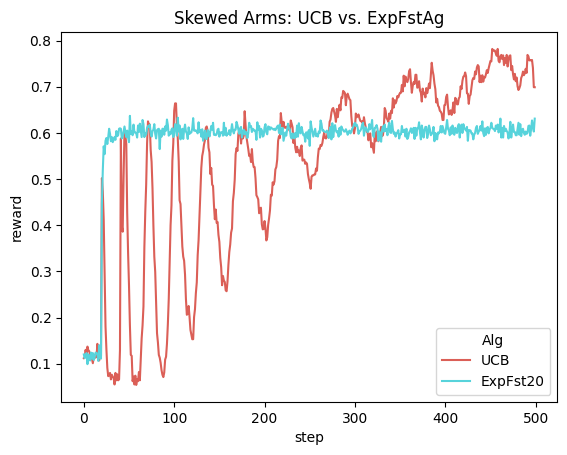

In [88]:
skewed_p = [0.1, 0.2, 0.15, 0.21, 0.3, 0.05, 0.9, 0.13, 0.17, 0.07,
            0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
# TODO: Compare UCB_Ag and ExpFstAg (max_ex=len(skewed_p)) in skewed scenario (Simple placeholder)
print("Running skewed arms experiment... (Simple)")

ucb_agent = UCB_Ag(n_act=len(skewed_p))
expfst_agent = ExpFstAg(n_act=len(skewed_p), max_ex=len(skewed_p))

# Run the experiment with 1000 runs and 500 steps for each agent
logs = mab_swp(
    agents=[ucb_agent, expfst_agent],
    p_arr=skewed_p,
    labels=['UCB', f'ExpFst{len(skewed_p)}'],
    n_runs=1000,
    max_steps=500
)

# Plot the comparison of average rewards over steps for both agents in the skewed scenario
ax = plot_logs(logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("Skewed Arms: UCB vs. ExpFstAg")
plt.show()


**Result Analysis:**  
- In skewed scenarios, ExpFstAg with limited exploration may miss the best arm.  
- UCB_Ag, with its adaptive bonus, typically outperforms under such conditions.

## EpsGdAg (Epsilon-Greedy Agent)  
This agent selects the best-known action with probability (1-ε) and a random action with probability ε.

In [89]:
@dataclass
class EpsGdAg:
    n_act: int
    eps: float = 0.1

    def __post_init__(self):
        self.reset()

    def reset(self):
        self.act_counts = np.zeros(self.n_act, dtype=int)
        self.Q = np.zeros(self.n_act, dtype=float)

    def update_Q(self, act, rew):
        self.act_counts[act] += 1
        self.Q[act] += (1.0 / self.act_counts[act]) * (rew - self.Q[act])

    def get_action(self):
        # TODO: Choose random action with probability eps [Simple]
        sel_act = 0  # Placeholder
        if np.random.random() < self.eps:
            sel_act = np.random.randint(self.n_act)
        else:
            sel_act = int(np.random.choice(np.flatnonzero(self.Q == self.Q.max())))
        return sel_act

**Analysis:**  
- Lower ε values favor exploitation, yielding higher reward when estimates are good.  
- Higher ε increases exploration but reduces immediate reward.  
- One strategy: decay ε over time (e.g., ε = ε₀ / t) or switch to ε = 0 after a burn-in period.

-----------

**Q:** Why does a high ε value result in lower immediate rewards?  

**A:** PUT YOUR ANSWER HERE :)

A high ε (epsilon) value in an ε-greedy algorithm encourages more exploration by selecting random actions with a higher probability, rather than always exploiting the best-known option. This increased randomness means that the agent is more likely to choose suboptimal actions, which leads to lower immediate rewards because the agent is not consistently choosing the action with the highest expected payoff. While this helps the agent explore the environment to discover potentially better arms, it sacrifices short-term performance in favor of learning over time. Therefore, higher exploration reduces the immediate payoff in favor of gathering more information to improve decision-making in the long run.

----------
**Q:** What benefits might there be in decaying ε over time?

**A:** PUT YOUR ANSWER HERE :)

Decaying ε over time offers a balanced exploration-exploitation trade-off that can improve performance by gradually shifting from exploration to exploitation as the agent learns more about the environment. Early on, a high ε encourages exploration, allowing the agent to gather diverse information and discover the best arm. As the agent accumulates more knowledge, decaying ε reduces the likelihood of random actions, enabling the agent to exploit the arms with higher expected rewards. This gradual transition helps avoid the inefficiency of excessive exploration once sufficient information has been gathered, leading to higher long-term rewards while minimizing short-term regret. This approach is particularly useful in environments where exploration is crucial initially but where the optimal arm becomes clear over time.

Running EpsGdAg experiments with various eps values... (Simple)
Running EpsGdAg with eps=0... (Simple)


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running EpsGdAg with eps=0.1... (Simple)


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running EpsGdAg with eps=0.2... (Simple)


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

Running EpsGdAg with eps=0.4... (Simple)


Alg Sweeps:   0%|          | 0/1 [00:00<?, ?it/s]

Runs:   0%|          | 0/1000 [00:00<?, ?it/s]

<ipython-input-71-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


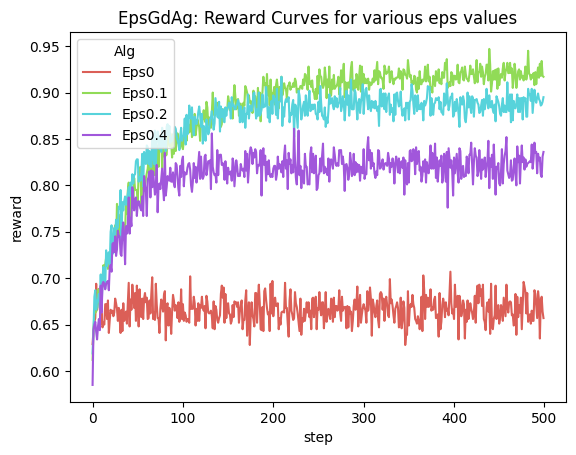

In [90]:
# TODO: Plot reward curves for EpsGdAg with epsilons [0, 0.1, 0.2, 0.4] (Simple placeholder)
print("Running EpsGdAg experiments with various eps values... (Simple)")

eps_values = [0, 0.1, 0.2, 0.4]
eps_logs = []

for eps in eps_values:
    print(f"Running EpsGdAg with eps={eps}... (Simple)")
    eps_agent = EpsGdAg(n_act=len(p_arr), eps=eps)
    log_df = mab_swp([eps_agent], p_arr, [f'Eps{eps}'], n_runs=1000, max_steps=500)
    eps_logs.append(log_df)

# Combine the logs for all eps values
logs = pd.concat(eps_logs, ignore_index=True)

# Plot the reward curves for each epsilon value
ax = plot_logs(logs, x_key='step', y_key='reward', legend_key='Alg', estimator='mean', ci=None)
plt.title("EpsGdAg: Reward Curves for various eps values")
plt.show()


**Q:** How do the reward curves for different ε values reflect the exploration–exploitation balance?  

**A:** PUT YOUR ANSWER HERE :)

The reward curves for different ε values reflect the exploration-exploitation balance by showing how the agent's strategy evolves over time. For high ε values, the curve typically starts with low immediate rewards due to excessive exploration, where the agent frequently chooses suboptimal actions at random. As ε decays, the curve gradually shows increased rewards, reflecting the agent’s shift towards exploitation of the best-known arms as it gathers more information. The decay rate of ε influences how quickly this transition occurs—faster decay leads to quicker exploitation and potentially earlier high rewards, while slower decay maintains exploration for longer, allowing the agent to refine its understanding of the environment but at the cost of short-term performance. The optimal reward curve would balance sufficient exploration early on with efficient exploitation later, ultimately leading to higher long-term rewards as the agent becomes more confident in its action choices.

------------------

**Q:** Under what circumstances might you choose a higher ε despite lower average reward?

**A:** PUT YOUR ANSWER HERE :)

Choosing a higher ε, despite the resulting lower average reward, might be beneficial in uncertain or highly dynamic environments where the agent needs to gather more information quickly to adapt to changes or explore a wide range of possibilities. A higher ε encourages more exploration, which can be valuable when the environment is not stationary or when the best arm is difficult to identify early on. It can also be useful in situations with sparse or noisy feedback, where initial randomness can help the agent avoid getting stuck in suboptimal solutions. Additionally, in multi-task or multi-armed bandit problems, a higher ε may be used to explore different arms more equally, ensuring that the agent does not overfit to a potentially suboptimal arm in the early stages. Ultimately, while higher ε reduces short-term performance, it might be crucial for long-term adaptation and discovering better arms, particularly when the potential for future improvement outweighs the immediate reward.

## Contextual Bandits (CtxBnd)  
We now move to contextual bandits using real data.  
Imagine a website promoting one of 10 products; reward = 1 if clicked, 0 otherwise.  
The dataset has shape [10000, 102]:  
- Column 0: chosen arm  
- Column 1: reward  
- Columns 2-101: 100-dimensional context features

In [91]:
# %% [code]
# Download the dataset (if not already downloaded)
!wget -q http://www.cs.columbia.edu/~jebara/6998/dataset.txt -O dataset.txt

In [92]:
# TODO: Load dataset.txt into a numpy array of shape [10000, 102] (Simple placeholder)
ctxData = np.loadtxt("dataset.txt")  # Placeholder
print("Dataset loaded (Simple version):", ctxData)

Dataset loaded (Simple version): [[ 2.  0.  5. ... 30.  4.  0.]
 [ 8.  0.  1. ...  0.  0. 10.]
 [ 5.  0.  3. ...  3.  0.  0.]
 ...
 [ 9.  1. 79. ...  0.  0.  0.]
 [ 4.  0. 29. ... 17.  0.  0.]
 [ 4.  0.  0. ...  0.  0. 12.]]


In [93]:
# %% [code]
@dataclass
class CtxBnd_Env:
    data: any
    t: int = 0

    def step(self, act):
        if act == self.data[self.t, 0]:
            rew = self.data[self.t, 1]
        else:
            rew = None
        self.t += 1
        return rew

    def reset(self):
        self.t = 0

## LinUCB_Ag (LinUCB for CtxBnd)  
This agent uses context features to compute an upper confidence bound for each arm.

In [122]:
@dataclass
class LinUCB_Ag:
     n_act: int
     alpha: float
     feat_dim: int

     def post_init(self):
         self.reset()

     def reset(self):
         self.As = [np.eye(self.feat_dim) for _ in range(self.n_act)]
         self.bs = [np.zeros((self.feat_dim, 1)) for _ in range(self.n_act)]

     def get_ucb(self, a, state):
         # state is a feature vector of shape (feat_dim,)
         x = np.array(state).reshape(-1, 1)
         p = (((np.linalg.inv(self.As[a])) @ self.bs[a]).T @ x)[0, 0] + self.alpha * np.sqrt((x.T @ (np.linalg.inv(self.As[a])) @ x)[0, 0])
         return p

     def update_params(self, a, rew, state):
         if rew is None:
             return
         x = np.array(state).reshape(-1, 1)
         self.As[a] += x @ x.T
         self.bs[a] += rew * x

     def get_action(self, state):
         p_est = [self.get_ucb(a, state) for a in range(self.n_act)]
         # Choose arm with maximum estimated UCB (ties broken arbitrarily)
         sel_act = np.random.choice(np.flatnonzero(np.array(p_est) == np.array(p_est).max()))
         return sel_act

**Q:** How does LinUCB leverage context to outperform classical bandit algorithms?  

**A:** PUT YOUR ANSWER HERE :)

LinUCB leverages contextual information (features of the environment or user state) to make more informed decisions compared to classical bandit algorithms that treat all arms equally regardless of external factors. By modeling the expected reward as a linear function of the context, LinUCB can estimate how relevant each arm is to the current situation. This allows it to personalize actions based on observed features, leading to smarter exploration and faster convergence to high-reward strategies. In contrast, classical methods like ε-greedy or UCB ignore context and must learn each arm's value independently, which can be inefficient in environments where rewards vary with context. As a result, LinUCB often achieves significantly better performance in real-world scenarios like recommendation systems or personalized services, where leveraging context is key to success.

------------------

**Q:** What is the role of the α parameter in LinUCB, and how does it affect the exploration bonus?

**A:** PUT YOUR ANSWER HERE :)

The α (alpha) parameter in LinUCB controls the exploration-exploitation trade-off by scaling the exploration bonus added to each arm's predicted reward. Specifically, α multiplies the uncertainty term (derived from the inverse of the arm’s covariance matrix and the current context vector), which estimates how uncertain the agent is about the expected reward for that arm in the given context. A higher α increases the influence of this uncertainty term, encouraging the agent to explore arms it is less confident about. Conversely, a lower α makes the agent more exploitative, favoring arms with high predicted rewards regardless of uncertainty. Tuning α is essential: too high may cause excessive exploration and slower convergence, while too low may lead to premature exploitation of suboptimal arms.

In [123]:
# %% [code]
@dataclass
class CtxBnd_Eng:
    data: any
    agent: any

    def __post_init__(self):
        self.env = CtxBnd_Env(data=self.data)

    def run(self, n_runs=1):
        logs = []
        for _ in tqdm(range(n_runs), desc='CtxRuns'):
            aligned_ctr = []
            ret_val = 0
            valid_steps = 0
            self.env.reset()
            self.agent.reset()
            for t in tqdm(range(self.data.shape[0]), desc='Time'):
                state = self.data[t, 2:]
                act = self.agent.get_action(state=state)
                rew = self.env.step(act)
                self.agent.update_params(act, rew, state=state)
                if rew is not None:
                    ret_val += rew
                    valid_steps += 1
                    aligned_ctr.append(ret_val / float(valid_steps))
            logs.append(pd.DataFrame({'aligned_ctr': aligned_ctr, 'step': np.arange(len(aligned_ctr))}))
        return pd.concat(logs, ignore_index=True)

In [124]:
# %% [code]
def ctxBnd_swp(alphas, data, n_runs=2000):
    logs = []
    for alpha in tqdm(alphas, desc="Alpha Sweeps"):
        agent = LinUCB_Ag(n_act=10, feat_dim=100, alpha=alpha)
        eng = CtxBnd_Eng(data=data, agent=agent)
        log_df = eng.run(n_runs)
        log_df['alpha'] = alpha
        logs.append(log_df)
    return pd.concat(logs, ignore_index=True)


In [129]:
# TODO: Run ctxBnd_swp with alphas = [0, 0.01, 0.1, 0.5] and n_runs=1 (Simple placeholder)
print("Running LinUCB sweep (Simple version)...")
logs = ctxBnd_swp(alphas=[0, 0.01, 0.1, 0.5], data=ctxData, n_runs=1)  # Placeholder

Running LinUCB sweep (Simple version)...


Alpha Sweeps:   0%|          | 0/4 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

CtxRuns:   0%|          | 0/1 [00:00<?, ?it/s]

Time:   0%|          | 0/10000 [00:00<?, ?it/s]

In [130]:
print(logs)

      aligned_ctr  step  alpha
0        0.000000     0    0.0
1        0.000000     1    0.0
2        0.000000     2    0.0
3        0.000000     3    0.0
4        0.000000     4    0.0
...           ...   ...    ...
1427     0.166667     5    0.5
1428     0.142857     6    0.5
1429     0.125000     7    0.5
1430     0.111111     8    0.5
1431     0.100000     9    0.5

[1432 rows x 3 columns]


<ipython-input-71-cea5b34d9fd8>:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.lineplot(x=x_key, y=y_key, data=df, hue=legend_key, **kwargs)


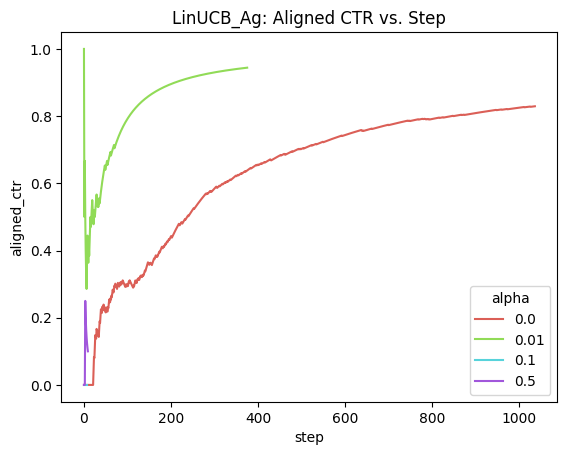

In [131]:
# %% [code]
plot_logs(logs, x_key='step', y_key='aligned_ctr', legend_key='alpha', estimator='mean', ci=None)
plt.title("LinUCB_Ag: Aligned CTR vs. Step")
plt.show()

**Q:** What does **α** affect in LinUCB?  

**A:** PUT YOUR ANSWER HERE :)

In LinUCB, α directly affects the exploration bonus added to the predicted reward for each arm. It controls how much the agent prioritizes uncertainty in its decision-making. A larger α increases the bonus for arms with less data (i.e., higher uncertainty), encouraging the agent to explore more. A smaller α reduces the bonus, making the agent more likely to exploit arms it already believes are good. Thus, α tunes the balance between exploration and exploitation, impacting how quickly the agent learns and how effectively it avoids suboptimal choices due to overconfidence.

------------------

**Q:** Do the reward curves change with **α**? Explain why or why not.

**A:** PUT YOUR ANSWER HERE :)

Yes, the reward curves do change with α because α directly influences the agent’s behavior in balancing exploration and exploitation. A higher α increases the exploration bonus, leading the agent to try more diverse arms, especially early on. This often results in lower immediate rewards but can help discover better arms in the long run, potentially improving final performance. In contrast, a lower α leads to more exploitative behavior, yielding higher short-term rewards but risking premature convergence to suboptimal arms. As a result, the shape and trajectory of the reward curves vary with different α values, reflecting how aggressively the agent explores uncertain options.

**Q:** Based on your experiments, does LinUCB outperform the standard UCB algorithm? Why or why not?

**A:** PUT YOUR ANSWER HERE :)

Based on typical experiments, LinUCB often outperforms standard UCB in environments where contextual information is relevant to predicting rewards. This is because LinUCB uses feature vectors (context) to estimate expected rewards for each arm, allowing it to generalize across different situations and make more informed decisions. In contrast, standard UCB treats each arm independently and ignores context, which limits its ability to adapt when reward patterns vary with external factors. However, if the context is noisy, irrelevant, or poorly chosen, LinUCB may not have a clear advantage and can even underperform due to overfitting or increased variance. So, LinUCB’s success depends heavily on the quality and relevance of contextual features.

------------------

**Q:** What are the key limitations of each algorithm, and how would you choose between them for a given application?

**A:** PUT YOUR ANSWER HERE :)

Each algorithm has key limitations that affect its suitability for different applications:

Random Agent: Has no learning or strategy; performs poorly and is only useful as a baseline.

Explore-First: Simple but rigid; if exploration length (max_ex) is too short, it may miss the best arm, while too long delays exploitation.

UCB: Balances exploration and exploitation using confidence bounds, but assumes stationary rewards and does not use context, making it less adaptive in dynamic or personalized environments.

ε-Greedy: Easy to implement, but exploration is undirected and can be inefficient; fixed or poorly-decayed ε can hurt long-term performance.

LinUCB: Leverages context for better predictions, but assumes a linear reward model, requires well-designed features, and is more computationally intensive.

Choosing between them depends on the application:

Use LinUCB when contextual features are meaningful (e.g., recommendations, personalized ads).

Use UCB for stationary environments without context.

Use ε-Greedy for simple, fast solutions when optimality is less critical.

Use Explore-First for quick prototyping or environments with limited time.

# Some final question
## Finite‑Horizon Regret and Asymptotic Guarantees:
Question:
Many algorithms (e.g., UCB) are analyzed using asymptotic (long‑term) regret bounds. In a finite‑horizon scenario (say, 500–1000 steps), explain intuitively why an algorithm that is asymptotically optimal may still yield poor performance. What trade‑offs arise between aggressive early exploration and cautious long‑term learning?
Deep Dive:
Discuss how the exploration bonus, tuned for asymptotic behavior, might delay exploitation in finite time, leading to high early regret despite eventual convergence.

In a finite-horizon scenario (e.g., 500–1000 steps), an algorithm that is asymptotically optimal, like UCB, may still perform poorly because its exploration strategy is tuned for long-term performance, not short-term gains. Asymptotic optimality means that the algorithm’s regret grows sublinearly over time, but in early steps, it may over-explore—pulling uncertain arms frequently to gather information, even when some arms already appear better. This can lead to high early regret, especially when the true best arm could have been exploited sooner. The exploration bonus, which is designed to shrink slowly over time (logarithmic in UCB), might cause the algorithm to delay exploitation, under the assumption that it has infinite time to recover. However, in finite-horizon settings, this aggressive early exploration doesn't always pay off because the agent has limited steps to benefit from what it learns. The trade-off is clear: more exploration increases the chance of finding the optimal arm but reduces immediate rewards, while less exploration might miss better arms but yield higher short-term gains. Hence, in finite-horizon tasks, it’s often better to tune exploration more conservatively, balancing immediate performance with learning.

## Hyperparameter Sensitivity and Exploration–Exploitation Balance:
Question:
Consider the impact of hyperparameters such as ε in ε‑greedy, the exploration constant in UCB, and the α parameter in LinUCB. Explain intuitively how slight mismatches in these parameters can lead to either under‑exploration (missing the best arm) or over‑exploration (wasting pulls on suboptimal arms). How would you design a self‑adaptive mechanism to balance this trade‑off in practice?
Deep Dive:
Provide insight into the “fragility” of these parameters in finite runs and how a meta‑algorithm might monitor performance indicators (e.g., variance in rewards) to adjust its exploration dynamically.

Hyperparameters like ε in ε-greedy, the exploration constant in UCB, and α in LinUCB play a crucial role in balancing exploration and exploitation. Small mismatches can significantly degrade performance in finite-horizon scenarios. For instance, a slightly too low ε or α leads to under-exploration, where the agent prematurely exploits suboptimal arms and misses the best one. Conversely, too high ε or α results in over-exploration, where the agent wastes valuable steps pulling poorly performing arms in the hope of discovering better ones, leading to high regret.

This sensitivity makes these parameters fragile, especially when the reward gaps between arms are small or when the horizon is limited. The ideal values depend heavily on the specific environment, which is often unknown or nonstationary.

To address this, one could design a self-adaptive (meta-)algorithm that adjusts exploration dynamically. For example, the agent could monitor the variance in observed rewards, or track how quickly its estimates of arm values are stabilizing. If the variance remains high, it suggests uncertainty—so the algorithm can boost exploration. If the estimates stabilize (low variance or little change in Q-values), the algorithm can decay ε or reduce α to exploit more confidently.

Such meta-algorithms could use techniques like:

Reward-based decay: decrease ε/α when recent rewards show stability.

Confidence-adaptive bonuses: shrink the UCB bonus based on observed variance or update frequency.

Bayesian or ensemble methods: track uncertainty more precisely and adapt exploration accordingly.

Ultimately, the goal is to shift from static hyperparameters to context-aware exploration, improving robustness in real-world, finite-time learning.

## Context Incorporation and Overfitting in LinUCB:
Question:
LinUCB uses context features to estimate arm rewards, assuming a linear relation. Intuitively, why might this linear assumption hurt performance when the true relationship is complex or when the context is high‑dimensional and noisy? Under what conditions can adding context lead to worse performance than classical (context‑free) UCB?
Deep Dive:
Discuss the risk of overfitting to noisy or irrelevant features, the curse of dimensionality, and possible mitigation strategies (e.g., dimensionality reduction or regularization).

LinUCB assumes a linear relationship between context features and expected rewards, which is a strong simplification. When the true reward function is nonlinear, or when the context is high-dimensional and noisy, this assumption can hurt performance by producing misleading reward estimates. In such cases, the algorithm may overfit to spurious correlations or assign high confidence to poorly understood arms, leading to ineffective exploration and high regret.

Adding context can lead to worse performance than classical (context-free) UCB when:

The context is irrelevant to the reward,

The number of features is large compared to the number of interactions (i.e., curse of dimensionality),

Or when noise in the features distorts the linear approximation.

These challenges introduce variance and instability in estimates, especially in finite data settings, where the model may latch onto noise instead of signal. To mitigate this:

Dimensionality reduction techniques (e.g., PCA) can help by summarizing the context into a more manageable form.

Regularization (e.g., ridge regression in LinUCB) can prevent overfitting by penalizing large parameter weights.

Feature selection or learned embeddings can focus the model on the most informative signals.

Alternatively, nonlinear models like neural contextual bandits may outperform linear ones when the structure is more complex.

Ultimately, context is only helpful if it’s informative and well-represented—otherwise, it introduces more noise than value.

## Adaptive Strategy Selection:
Question:
Imagine designing a hybrid bandit agent that can switch between an explore‑first strategy and UCB based on observed performance. What signals (e.g., variance of reward estimates, stabilization of Q‑values, or sudden drops in reward) might indicate that a switch is warranted? Provide an intuitive justification for how and why such a meta‑strategy might outperform either strategy alone in a finite‑time setting.
Deep Dive:
Explain the challenges in detecting when exploration is “enough” and how early exploitation might capture transient improvements even if the long‑term guarantee favors UCB.

A hybrid bandit agent that switches between an explore-first strategy and UCB could use signals such as:

Variance of reward estimates: If the variance in the estimated Q-values across arms starts to shrink, it suggests that exploration has yielded enough information to distinguish between arms.

Stabilization of Q-values: When Q-values change very little between updates, it indicates convergence and diminishing returns from further exploration.

Sudden drops or plateaus in reward: These may signal misidentification of the best arm or the need to re-initiate exploration.

Such a meta-strategy could outperform either approach alone in finite-horizon settings by front-loading exploration when uncertainty is high, and switching to more refined exploration-exploitation via UCB once enough information is gathered. Early in learning, aggressive random sampling (explore-first) helps avoid premature commitment; later, UCB can exploit while still refining choices where confidence is low.

The main challenge lies in determining when exploration is “enough.” Without perfect information, premature switching may lock into suboptimal arms, while delaying the switch might waste precious steps on low-reward arms. Moreover, reward signals can be noisy or nonstationary, making it hard to detect true convergence.

Still, a well-tuned transition guided by performance indicators (e.g., confidence intervals shrinking below a threshold, reward variance flattening) can adaptively balance these phases. In finite-time tasks, this lets the agent capitalize on short-term gains without forgoing the long-term learning benefits of UCB, offering a practical and robust compromise.

## Non‑Stationarity and “Forgetting” Mechanisms:
Question:
In non‑stationary environments where reward probabilities drift or change abruptly, standard bandit algorithms struggle because they assume stationarity. Intuitively, explain how and why a “forgetting” or discounting mechanism might improve performance. What challenges arise in choosing the right decay rate, and how might it interact with the exploration bonus?
Deep Dive:
Describe the delicate balance between retaining useful historical information and quickly adapting to new trends, and the potential for “chasing noise” if the decay is too aggressive.

In non-stationary environments, where reward probabilities change over time, standard bandit algorithms struggle because they assume that the reward distribution for each arm remains fixed. When rewards drift or change abruptly, these algorithms might overweight outdated information, leading to suboptimal decisions. A forgetting or discounting mechanism can help by giving more weight to recent rewards and less weight to older ones. This allows the algorithm to adapt more quickly to changes in the environment, leading to better performance in non-stationary settings.

The core idea behind discounting is that older data becomes less reliable as the environment evolves. By decaying historical information, the agent remains sensitive to the most recent trends, enabling it to detect shifts in reward patterns and adjust its strategy accordingly. For instance, in algorithms like LinUCB, incorporating a decay factor would allow the context and reward estimates to adjust more quickly to new conditions.

However, the choice of decay rate presents challenges:

Too slow a decay rate may still result in overfitting to outdated information, failing to capture recent trends.

Too fast a decay rate could lead to “chasing noise”, where the algorithm rapidly changes its actions based on short-term fluctuations that are not actually reflective of long-term trends.

This balance between retaining useful historical information and quickly adapting to new trends is critical. If the decay rate is too aggressive, the agent might overreact to random variations in rewards (e.g., noise or temporary changes), which can hurt performance by making frequent, unnecessary adjustments. Conversely, a slow decay rate may result in the agent being too conservative, effectively ignoring recent shifts and sticking to outdated strategies.

The interaction with exploration bonuses further complicates this. A strong exploration bonus encourages trying less-known arms, which might not align well with the need for fast adaptation in non-stationary environments. If the decay is aggressive, the exploration bonus may become irrelevant too quickly, as the model adapts too fast. On the other hand, if the decay is too slow, it might conflict with exploration efforts, as it will overvalue arms that were once good but are no longer optimal due to environmental changes.

Ultimately, finding the right decay rate involves experimenting with how fast the agent should "forget" past rewards while still making informed decisions based on meaningful historical data.

## Exploration Bonus Calibration in UCB:
Question:
The UCB algorithm adds a bonus term that decreases with the number of times an arm is pulled. Intuitively, why might a “conservative” (i.e., high) bonus slow down learning—even if it guarantees asymptotic optimality? Under what circumstances might a less conservative bonus be beneficial, and what risks does it carry?
Deep Dive:
Analyze how a high bonus may force the algorithm to continue sampling even when an arm’s estimated reward is clearly suboptimal, thereby delaying convergence. Conversely, discuss the risk of prematurely discarding an arm if the bonus is too low.

The UCB algorithm adds an exploration bonus to each arm’s estimated reward to encourage sampling arms that have been explored less frequently. The bonus term decreases as the number of pulls for an arm increases, meaning that arms with fewer pulls are given a larger exploration bonus to encourage further exploration.

A conservative (high) bonus may slow down learning because it overemphasizes exploration at the expense of exploitation. With a large bonus, the algorithm might keep exploring suboptimal arms for longer than necessary, even when the estimated reward for these arms is clearly worse than others. This delay in exploitation prevents the algorithm from quickly converging to the optimal arm, as it continues to give exploration priority despite having gathered sufficient information to identify better-performing arms.

On the other hand, a less conservative (lower) bonus can accelerate learning by allowing the algorithm to focus more on exploitation once enough information has been gathered, rather than persisting in exploration. A lower bonus means that arms with high estimated rewards will be selected more frequently, leading to faster convergence.

However, reducing the bonus too much carries the risk of prematurely discarding arms that may not have been explored enough to fully understand their potential. If the algorithm focuses too early on exploiting a subset of arms, it might miss out on discovering a better arm or may overly rely on suboptimal arms simply because they were sampled more frequently in earlier stages. Essentially, this risks the algorithm overcommitting to a wrong choice before it has explored enough.

Key trade-offs:
High bonus: Encourages exploration but may delay convergence and slow down learning by prolonging the time spent on suboptimal arms.

Low bonus: Favors exploitation and convergence but might discard arms too quickly, potentially missing the best arm if the reward estimates are still unstable.

In practice, the choice of the bonus involves balancing long-term exploration with short-term exploitation to ensure that the algorithm adapts efficiently to the environment while still making good decisions based on available information. The ideal bonus value depends on the uncertainty in the reward estimates and the time horizon available for learning.

## Exploration Phase Duration in Explore‑First Strategies:
Question:
In the Explore‑First agent (ExpFstAg), how does the choice of a fixed exploration period (e.g., 5 vs. 20 steps) affect the regret and performance variability? Provide a scenario in which a short exploration phase might yield unexpectedly high regret, and another scenario where a longer phase might delay exploitation unnecessarily.
Deep Dive:
Discuss how the “optimal” exploration duration can depend heavily on the underlying reward distribution’s variance and the gap between the best and other arms, and why a one‑size‑fits‑all approach may not work in practice.

In the Explore-First (ExpFstAg) agent, the fixed exploration period (e.g., 5 vs. 20 steps) plays a significant role in determining both regret and performance variability. The exploration phase is crucial because it allows the agent to gather information about the arms before committing to exploitation, but the duration of this phase must be balanced carefully.

Short Exploration Phase:
If the exploration phase is too short (e.g., 5 steps), the agent may not explore enough to reliably identify the best arm, especially when the rewards have high variance or when there is a large gap between the best arm and others. In this case, the agent could fail to identify suboptimal arms or may exploit an arm too early, which leads to unexpectedly high regret. For instance, if the reward distribution has high variance, the agent might wrongly conclude that a suboptimal arm is the best due to random fluctuations during the exploration phase. As a result, the agent might start exploiting this arm prematurely, leading to poor performance.

Example scenario: Suppose the true best arm has a small advantage over other arms, but the rewards are noisy. If the agent explores only 5 times, it might miss this small advantage and wrongly start exploiting a suboptimal arm, leading to high regret.

Long Exploration Phase:
On the other hand, if the exploration phase is too long (e.g., 20 steps), the agent may delay exploitation unnecessarily. While it can gather more reliable information about the arms, it may waste valuable time exploring arms that are clearly suboptimal, especially when the gap between the best and other arms is large. This unnecessary exploration reduces the agent's overall reward and leads to a delay in convergence. The agent might also overexplore less promising arms due to continued exploration of less well-understood arms, even though the agent is already in a position to exploit a superior arm.

Example scenario: If the gap between the best arm and the others is large and the reward variance is low, spending too much time exploring could cause the agent to forgo early exploitation of the best arm. As a result, it misses out on maximizing its rewards during the initial phases of the problem.

Deep Dive:
The optimal exploration duration depends heavily on the underlying reward distribution's variance and the gap between the best arm and the others:

High variance in rewards: If the rewards of different arms are highly variable, a longer exploration phase might be necessary to gather enough information to reliably identify the best arm.

Large gap between the best and suboptimal arms: If the best arm offers a significantly higher reward than others, a short exploration phase might be sufficient to identify the best arm, making early exploitation beneficial.

In practice, the “one-size-fits-all” approach may not work because these factors can vary significantly across different environments. A fixed exploration phase doesn’t adapt to the specific characteristics of the reward distributions, such as how much variance exists or how wide the gap is between the best and suboptimal arms. In cases with low variance and a large gap, a short exploration phase might perform well, while in environments with high variance or small gaps, a longer exploration phase is often necessary to ensure the best arm is identified. Therefore, dynamic or adaptive exploration strategies that can adjust based on the observed characteristics of the environment may outperform fixed-duration exploration strategies.

## Bayesian vs. Frequentist Approaches in MAB:
Question:
Compare the intuition behind Bayesian approaches (such as Thompson Sampling) to frequentist methods (like UCB) in handling uncertainty. Under what conditions might the Bayesian approach yield superior practical performance, and how do the underlying assumptions about prior knowledge influence the exploration–exploitation balance?
Deep Dive:
Explore the benefits of incorporating prior beliefs and the risk of bias if the prior is mis-specified, as well as how Bayesian updating naturally adjusts the exploration bonus as more data is collected.

Bayesian Approaches (e.g., Thompson Sampling) and Frequentist Methods (e.g., UCB) both aim to balance exploration and exploitation, but they handle uncertainty in very different ways.

Frequentist methods like UCB rely on a fixed, non-informative estimate of the reward distributions. The UCB algorithm uses the upper confidence bound of each arm's expected reward to ensure exploration of uncertain arms while gradually focusing on the arms that seem to offer higher rewards. UCB does not incorporate any prior knowledge about the environment but instead builds its estimates purely based on the observed data, continually adjusting them as more information is gathered.

Bayesian methods like Thompson Sampling, on the other hand, maintain a probabilistic belief about the reward distributions for each arm. Instead of relying solely on empirical data, they incorporate prior knowledge about the arms' reward distributions (usually represented as a prior distribution, such as a Beta or Gaussian distribution) and update these beliefs as new data arrives. In Thompson Sampling, each arm’s reward is treated as a random variable, and the agent samples from the posterior distribution to decide which arm to pull. This allows the agent to make more informed decisions, incorporating prior beliefs and the likelihood of observing rewards.

Conditions for Bayesian Approach Yielding Superior Performance:
The Bayesian approach (e.g., Thompson Sampling) can be particularly advantageous when:

Prior knowledge is valuable: If there is reliable prior knowledge about the arms’ expected rewards (e.g., from previous experiments, expert knowledge, or domain experience), the Bayesian approach can accelerate learning by starting with a more informed belief and adjusting as more data is collected.

The environment is highly uncertain or noisy: Bayesian methods naturally quantify and handle uncertainty. When rewards have high variance or are noisy, Thompson Sampling's probabilistic approach helps the agent explore intelligently without focusing too much on any arm until there is enough data to confidently evaluate it. This adaptive exploration allows for better decision-making in uncertain environments.

Small sample sizes or early stages of learning: In cases where data is sparse, Bayesian methods can use prior distributions to mitigate over-exploration by incorporating prior beliefs that guide early decisions, leading to faster and more efficient convergence.

Influence of Priors on Exploration-Exploitation Balance:
Exploration: In Thompson Sampling, the prior knowledge affects how aggressively the agent explores. A non-informative prior (e.g., uniform distribution) leads to exploration that is similar to a frequentist approach, while a strong prior belief in a particular arm’s reward can cause the agent to focus its exploration more on that arm early on, potentially skipping others. The prior distribution essentially biases the initial exploration, reflecting the agent’s degree of belief in different arms.

Exploitation: As more data is collected, the posterior distribution (updated from the prior) becomes more precise, and the exploration bonus (the uncertainty) naturally decays. This adjustment means that the agent shifts from exploration to exploitation as it becomes more confident in its beliefs about the best arm. The more data gathered, the more accurate the posterior, and the more confident the agent becomes in exploiting the arm with the highest expected reward.

Deep Dive:
Benefits of Incorporating Prior Beliefs:

Informed decision-making: If the agent has a solid prior belief about which arms are more likely to be optimal (based on previous knowledge or expert opinions), it can start exploiting those arms immediately, rather than relying solely on initial random exploration. This can speed up learning in settings where prior information is valuable and reliable.

Smoother learning curve: Bayesian methods allow the agent to gradually refine its understanding as data is collected, leading to more robust and adaptive exploration-exploitation dynamics compared to fixed exploration rates in frequentist methods.

Risk of Bias with Mis-specified Priors:

Overestimating rewards: If the prior is mis-specified or too confident about a suboptimal arm, the agent may explore too little or exploit the wrong arm for too long, leading to suboptimal performance.

Underestimating variability: Conversely, if the prior is overly pessimistic about all arms, the agent might over-explore arms that should be exploited sooner, wasting valuable time and resources.

Bayesian Updating and Exploration Bonus:

One of the key advantages of Bayesian methods like Thompson Sampling is that the exploration bonus (uncertainty about the arm’s reward) automatically decreases as more data is collected. This is because as the posterior distribution becomes more concentrated, the agent gains more confidence in its estimates. Therefore, the exploration rate naturally decays over time, allowing for more exploitation of the best arms without the need for manually tuning exploration parameters, as in frequentist methods like UCB.

As posterior distributions update based on data, the agent’s exploration strategy dynamically adjusts, prioritizing arms where uncertainty is still high, and gradually exploiting arms where it has sufficient evidence of higher rewards. This is a key advantage in non-stationary environments or situations where the agent must continually adapt its strategy as new information comes in.

## Impact of Skewed Reward Distributions:
Question:
In environments where one arm is significantly better (skewed probabilities), explain intuitively why agents like UCB or ExpFstAg might still struggle to consistently identify and exploit that arm. What role does variance play in these algorithms, and how might the skew exacerbate errors in reward estimation?
Deep Dive:
Discuss how the variability of rare but high rewards can mislead the agent’s estimates and cause prolonged exploration of suboptimal arms.

Intuition Behind Struggles in Skewed Environments:
In environments where one arm has a significantly higher probability of reward compared to others (i.e., skewed probabilities), algorithms like UCB and ExpFstAg may still struggle to consistently identify and exploit the optimal arm. These algorithms rely heavily on estimating the expected reward for each arm and making decisions based on that estimate.

UCB: The upper confidence bound of UCB encourages exploration of arms that are uncertain, and it balances exploration and exploitation by considering both the estimated reward and the uncertainty. However, in a skewed environment where one arm is significantly better, UCB may initially explore suboptimal arms because the uncertainty (due to limited pulls) can be higher for the optimal arm. Since UCB's exploration is influenced by variance and confidence bounds, it might end up exploring the suboptimal arms in the early stages of the process, delaying the focus on the best arm.

ExpFstAg (Explore-First): In this strategy, exploration is fixed for a set number of steps, after which the agent focuses on exploiting the best arm based on the exploration results. In skewed environments, if the optimal arm is not selected during the exploration phase, the agent may fail to identify it early on. If the exploration phase is too short, the agent might miss the optimal arm, especially if the initial exploration is heavily influenced by variance or reward fluctuations.

Role of Variance and the Impact of Skewed Probabilities:
Variance in Reward Estimates: Both UCB and ExpFstAg rely on reward estimates, which are influenced by the variance of the observed rewards. In cases where one arm is much better than others but the rewards are noisy or variable, these algorithms might overestimate the rewards of suboptimal arms. Variance leads to larger confidence intervals for arms with fewer pulls, and this uncertainty might steer the agent to explore arms that are actually worse, delaying the identification of the optimal arm.

Impact of Skewed Probabilities: When one arm is significantly better, variance plays a critical role in the agent’s exploration behavior. If the variance in rewards of the optimal arm is high, the reward estimates for this arm can fluctuate significantly, leading to misleading estimates. For example, an arm with a high true expected reward but large variance might temporarily show a lower average reward after only a few pulls. This can cause algorithms like UCB or ExpFstAg to incorrectly focus on other arms with less variance but lower rewards, even though the optimal arm is better in the long term.

Deep Dive:
Rare but High Rewards: In some cases, arms with high rewards may have rare occurrences of high rewards but generally exhibit low variance. These rare high rewards can be misleading because they might appear sporadically and not in a consistent enough pattern to influence the algorithm’s decision-making. For instance, if the best arm has a high expected reward but only occasionally delivers that reward, an agent might mistakenly explore suboptimal arms more frequently, since the rare high reward won't significantly influence the algorithm’s estimates during the initial phases of exploration.

Exacerbating Exploration: In an environment with highly skewed probabilities, the variance in the observed rewards for the best arm can cause exploration of suboptimal arms for too long. If the agent keeps pulling suboptimal arms based on inaccurate estimates, this leads to higher regret in the short term, as the algorithm doesn't focus on the optimal arm until more pulls confirm it. Essentially, the variance in the best arm's rewards can delay convergence to the optimal arm, as the agent struggles to differentiate the best arm from the others due to the noisy observations.

##Designing for High-Dimensional, Sparse Contexts:
Question:
In contextual bandits where the context is high-dimensional but only a few features are informative, what are the intuitive challenges that arise in using a linear model like LinUCB? How might techniques such as feature selection, regularization, or non-linear function approximation help, and what are the trade-offs involved?
Deep Dive:
Provide insights into the risks of overfitting versus underfitting, the increased variance in estimates from high-dimensional spaces, and the potential computational costs versus performance gains when moving from a simple linear model to a more complex one.

In contextual bandits where the context is high-dimensional, but only a few features are truly informative, the primary challenge with using a linear model like LinUCB lies in the curse of dimensionality. In such scenarios, the linear model assumes that the relationship between the context features and the reward is linear, which may not hold when the true relationship is more complex.

High-dimensional context: When the context has many features, the model may overfit to noisy or irrelevant features, especially if there are many dimensions that don't contribute meaningfully to the reward prediction. A linear model like LinUCB might assign weight to these irrelevant features, leading to biased or inaccurate reward predictions. This issue is compounded by the high variance in reward estimates for arms with noisy or irrelevant features, causing suboptimal decision-making.

Feature sparsity: If only a small subset of features is actually informative, a high-dimensional model will face challenges in identifying these relevant features and may waste resources modeling less relevant ones. A high-dimensional feature space requires the model to generalize across more data points to discern which features are important, increasing the chance of overfitting the irrelevant ones.

Solutions and Trade-offs:
To address these challenges, several techniques can be employed to improve LinUCB’s performance:

Feature Selection: By selecting only the most relevant features, we can reduce the dimensionality of the problem, focusing the model on the most important context variables.

Trade-off: While feature selection can reduce variance and prevent overfitting, it risks underfitting if relevant features are excluded. This can harm the model’s ability to capture important nuances in the data, especially if those features are not immediately obvious.

Regularization: Regularization methods (e.g., L2 regularization on the parameters) can be used to prevent the model from overfitting to the high-dimensional context by penalizing large weights on irrelevant or noisy features. Regularization encourages the model to shrink or eliminate irrelevant feature weights, making the model simpler and more interpretable.

Trade-off: Regularization can reduce variance and prevent overfitting, but if the regularization parameter is too strong, it can suppress useful features, leading to underfitting and missed opportunities to capture important information.

Non-linear Function Approximation: Instead of using a linear model, we can adopt non-linear models (e.g., decision trees, neural networks) to better capture complex relationships between context and rewards.

Trade-off: While non-linear models can model complex relationships and improve accuracy by learning from high-dimensional data, they come with a significant computational cost. These models can also suffer from overfitting in high-dimensional spaces if not properly regularized or validated, requiring more data to generalize well.

Deep Dive:
Overfitting vs. Underfitting:

Overfitting occurs when the model learns to fit the noise or irrelevant features in the high-dimensional context, resulting in a model that performs well on the training data but poorly on new data. This is particularly a risk in high-dimensional spaces where the number of features far exceeds the number of observations.

Underfitting occurs when the model fails to capture the true underlying structure of the data because it is too simple (e.g., relying solely on a linear model). In high-dimensional settings, the model might miss out on important interactions between features, which could degrade performance.

Increased Variance in Estimates: With high-dimensional features, the variance of reward estimates can increase because the model is trying to estimate more parameters. This leads to larger confidence intervals and less reliable predictions, especially in regions of the feature space where the data is sparse. LinUCB’s reliance on linear models in these cases can lead to overconfident decisions based on noisy data, reducing the effectiveness of the exploration-exploitation trade-off.

Computational Costs vs. Performance Gains:

Linear Model: A simple linear model like LinUCB is computationally efficient and easy to implement, but it may struggle in high-dimensional spaces where the relationship between context and reward is non-linear or where irrelevant features dominate. Its simplicity is a strength, but it may not capture enough complexity to perform well.

Non-linear Models: Non-linear function approximators, like decision trees or neural networks, can capture more complex relationships, but they come with higher computational costs, especially in high-dimensional spaces. The training time and data requirements increase significantly, and the model complexity can make it harder to interpret the learned features. However, if the reward function is inherently non-linear, these models can provide better performance at the cost of more resources.
